In [1]:
import pandas as pd
import os
import numpy as np

cur_dir = os.getcwd()
path = os.path.join(cur_dir,'dataset','train.csv')
path

df_train = pd.read_csv( os.path.join(cur_dir,'dataset','train.csv'), sep=',' )
df_movies = pd.read_csv( os.path.join(cur_dir,'dataset','movies.csv'), sep='::' )
df_users = pd.read_csv( os.path.join(cur_dir,'dataset','users.csv'), sep='::' )
df_test = pd.read_csv( os.path.join(cur_dir,'dataset','test.csv'), sep=',' )
df_SampleSubmisson = pd.read_csv( os.path.join(cur_dir,'dataset','SampleSubmisson.csv'), sep=',' )

mean = df_train.Rating.mean()
std = df_train.Rating.std()
df_train['Rating_normalized'] = (df_train['Rating'] - mean)/std

all_user = np.concatenate([df_train.UserID,df_test.UserID],axis=0)
all_movie = np.concatenate([df_train.MovieID,df_test.MovieID],axis=0)
print(all_user.shape)
print(all_movie.shape)
all_user = np.unique(all_user)
all_movie = np.unique(all_movie)
print(all_user.shape)
print(all_movie.shape)


df_all_movie = pd.DataFrame({'movie_id':all_movie})
df_all_movie['movie_index'] = df_all_movie.index

df_all_user = pd.DataFrame({'user_id':all_user})
df_all_user['user_index'] = df_all_user.index


movie_id_to_index = df_all_movie.set_index('movie_id').to_dict()
movie_id_to_index = movie_id_to_index['movie_index']
user_id_to_index = df_all_user.set_index('user_id').to_dict()
user_id_to_index = user_id_to_index['user_index']

df_train['user_index'] =  df_train.apply(lambda row: user_id_to_index[row.UserID] ,axis=1)
df_train['movie_index'] =  df_train.apply(lambda row: movie_id_to_index[row.MovieID] ,axis=1)

df_train


user_train = df_train.user_index
movie_train = df_train.movie_index
rating_train = df_train.Rating


/data1/home/feynman52/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.
/data1/home/feynman52/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


(1000209,)
(1000209,)
(6040,)
(3706,)


# DNN

In [2]:
from keras.layers import Input, Dense, Embedding, Flatten, dot, add, concatenate
from keras.models import Model
from keras.utils import get_custom_objects
import keras.backend as K
from sklearn.utils import shuffle
import matplotlib.pylab as plt

Using TensorFlow backend.


In [3]:
n_users= len(user_train)
n_movies= len(movie_train)
latent_dim = 20

In [6]:
# build model---------------------------------------------------------
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))

user_vecter = Embedding(n_users, latent_dim, embeddings_initializer="random_normal")(user_input)
user_vecter = Flatten()(user_vecter)
movie_vecter = Embedding(n_movies, latent_dim, embeddings_initializer="random_normal")(movie_input)
movie_vecter = Flatten()(movie_vecter)

rating_predict = concatenate([user_vecter,movie_vecter])

rating_predict = Dense(20, activation='relu')(rating_predict)
rating_predict = Dense(20, activation='relu')(rating_predict)
rating_predict = Dense(1, activation='relu')(rating_predict)

model_dnn = Model([user_input,movie_input],rating_predict)

# compile model---------------------------------------------------------
def rmse(y_true, y_pred):
    y_pred = K.clip(y_pred, 1.0, 5.0)
    return K.sqrt(K.mean(K.pow(y_true - y_pred, 2)))
get_custom_objects().update({"rmse": rmse})

model_dnn.compile(loss="mse", optimizer="adam", metrics=[rmse])

model_dnn.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 20)        17997460    input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 20)        17997460    input_4[0][0]                    
__________________________________________________________________________________________________
flatten_3 

In [7]:
batch_size=1000
epochs = 10

user_train2, movie_train2, rating_train2 = shuffle(user_train, movie_train, rating_train)


history_dnn = model_dnn.fit([user_train2, movie_train2],
                    rating_train2,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    shuffle=True)

Train on 809885 samples, validate on 89988 samples
Epoch 1/10
809885/809885 [==============================] - 17s 22us/step - loss: 1.7823 - rmse: 1.1154 - val_loss: 0.8449 - val_rmse: 0.9189
Epoch 2/10
809885/809885 [==============================] - 17s 20us/step - loss: 0.8357 - rmse: 0.9137 - val_loss: 0.8356 - val_rmse: 0.9138
Epoch 3/10
809885/809885 [==============================] - 16s 20us/step - loss: 0.8253 - rmse: 0.9081 - val_loss: 0.8271 - val_rmse: 0.9091
Epoch 4/10
809885/809885 [==============================] - 16s 20us/step - loss: 0.8115 - rmse: 0.9005 - val_loss: 0.8117 - val_rmse: 0.9007
Epoch 5/10
809885/809885 [==============================] - 16s 20us/step - loss: 0.7900 - rmse: 0.8885 - val_loss: 0.7972 - val_rmse: 0.8926
Epoch 6/10
809885/809885 [==============================] - 16s 20us/step - loss: 0.7727 - rmse: 0.8787 - val_loss: 0.7886 - val_rmse: 0.8878
Epoch 7/10
809885/809885 [==============================] - 17s 20us/step - loss: 0.7585 - rmse: 

# dot

In [8]:
# build model---------------------------------------------------------
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))

user_vecter = Embedding(n_users, latent_dim, embeddings_initializer="random_normal")(user_input)
user_vecter = Flatten()(user_vecter)
movie_vecter = Embedding(n_movies, latent_dim, embeddings_initializer="random_normal")(movie_input)
movie_vecter = Flatten()(movie_vecter)
rating_predict = dot([user_vecter,movie_vecter],axes=1)

model_dot = Model([user_input,movie_input],rating_predict)

# compile model---------------------------------------------------------
def rmse(y_true, y_pred):
    y_pred = K.clip(y_pred, 1.0, 5.0)
    return K.sqrt(K.mean(K.pow(y_true - y_pred, 2)))
get_custom_objects().update({"rmse": rmse})

model_dot.compile(loss="mse", optimizer="adam", metrics=[rmse])

model_dot.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 20)        17997460    input_5[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 20)        17997460    input_6[0][0]                    
__________________________________________________________________________________________________
flatten_5 

In [9]:
batch_size=1000
epochs = 10
user_train2, movie_train2, rating_train2 = shuffle(user_train, movie_train, rating_train)

history_dot = model_dot.fit([user_train2, movie_train2],
                    rating_train2,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    shuffle=True)

Train on 809885 samples, validate on 89988 samples
Epoch 1/10
809885/809885 [==============================] - 16s 20us/step - loss: 11.0686 - rmse: 2.6477 - val_loss: 3.1489 - val_rmse: 1.7485
Epoch 2/10
809885/809885 [==============================] - 16s 20us/step - loss: 1.5730 - rmse: 1.2305 - val_loss: 1.0461 - val_rmse: 1.0195
Epoch 3/10
809885/809885 [==============================] - 16s 20us/step - loss: 0.9364 - rmse: 0.9655 - val_loss: 0.8853 - val_rmse: 0.9391
Epoch 4/10
809885/809885 [==============================] - 16s 20us/step - loss: 0.8573 - rmse: 0.9247 - val_loss: 0.8508 - val_rmse: 0.9210
Epoch 5/10
809885/809885 [==============================] - 16s 20us/step - loss: 0.8364 - rmse: 0.9136 - val_loss: 0.8388 - val_rmse: 0.9146
Epoch 6/10
809885/809885 [==============================] - 16s 20us/step - loss: 0.8263 - rmse: 0.9082 - val_loss: 0.8325 - val_rmse: 0.9112
Epoch 7/10
809885/809885 [==============================] - 16s 20us/step - loss: 0.8173 - rmse:

# plot

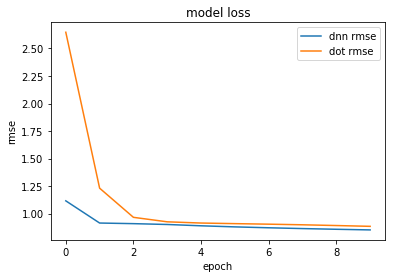

In [13]:


# plot
plt.plot(history_dnn.history['rmse'],label='dnn rmse')
plt.plot(history_dot.history['rmse'],label='dot rmse')
plt.title('model loss')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend()
plt.show()


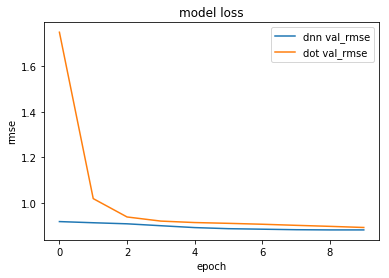

In [12]:


# plot
plt.plot(history_dnn.history['val_rmse'],label='dnn val_rmse')
plt.plot(history_dot.history['val_rmse'],label='dot val_rmse')
plt.title('model loss')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend()
plt.show()
